In [3]:
# %% [markdown]
# # Math 76.02 — Homework 5 (Problems 1–4 + Bonus)
# Utilities and plotting style

# %%
import numpy as np
import numpy.linalg as npl
import scipy.linalg as spla
import scipy.fft as sfft
import matplotlib.pyplot as plt

# Optional: CVXPY for convex optimization (ℓ1/TV and complex problems)
try:
    import cvxpy as cp
    _HAS_CVXPY = True
except Exception as e:
    _HAS_CVXPY = False
    print("Warning: cvxpy not available. Install it with `pip install cvxpy` to run the ℓ1/TV and complex LS problems.")

np.random.seed(42)

# --- Signal builders ---
def signal_sparse(n=200, s=10, scale=1.0):
    idx = np.random.permutation(n)[:s]
    f = np.zeros(n)
    f[idx] = scale * np.random.randn(s)
    return f

def signal_piecewise_constant(n=200):
    # f(t)=1 on (-1/4,0], f(t)=2 on [1/2,7/8], else 0; periodic in [-1,1]
    t = -1 + 2*np.arange(n)/n
    f = np.zeros_like(t)
    f[(t > -0.25) & (t <= 0.0)] = 1.0
    f[(t >= 0.5) & (t <= 0.875)] = 2.0
    return f

def signal_sawtooth(n=200):
    # 2-periodic sawtooth on (-1,1]: f(t) = -1-t for -1<t<=0; f(t)=1-t for 0<t<=1
    t = -1 + 2*np.arange(n)/n
    f = np.where(t<=0, -1 - t, 1 - t)
    return f

# --- Difference matrices (periodic) ---
def diff_matrix_first(n):
    L = np.zeros((n, n))
    for i in range(n-1):
        L[i, i] = -1.0
        L[i, i+1] = 1.0
    L[n-1, n-1] = -1.0
    L[n-1, 0] = 1.0
    return L

def identity_matrix(n):
    return np.eye(n)

# --- Gaussian PSF & blur matrices ---
def gaussian_psf_from_m_sigma(m=6, sigma=3.0):
    # Build symmetric kernel like assignment code
    tmp = np.linspace(0, 1, m+1)
    y = np.concatenate([-tmp[1:][::-1], tmp])
    psf = np.exp(-y**2/(2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)
    psf = psf / psf.sum()
    return psf

def blur_matrix_zero_boundary(psf, n):
    # Build n x n matrix A: (Af)[i] = (psf * f)[i] with zero-boundary, using "same" conv
    L = len(psf)
    if L % 2 == 0:
        raise ValueError("Use an odd-length psf.")
    A = np.zeros((n, n))
    for j in range(n):
        e = np.zeros(n); e[j] = 1.0
        y = np.convolve(e, psf, mode='same')
        A[:, j] = y
    return A

def blur_matrix_periodic(psf, n):
    # Periodic/circular convolution matrix via circulant embedding
    L = len(psf)
    if L % 2 == 0:
        raise ValueError("Use an odd-length psf.")
    m = (L - 1)//2
    h = np.zeros(n)
    h[0] = psf[m]                     # center
    for k in range(1, m+1):
        h[k]     = psf[m + k]         # positive shifts
        h[n - k] = psf[m - k]         # negative shifts
    # circulant needs first col c with c[0]=h[0], c[k]=h[n-k]
    c = np.r_[h[0], h[:0:-1]]
    C = spla.circulant(c)
    return C

# --- Noise ---
def add_relative_noise(g, rel=0.01):
    e = np.random.randn(*g.shape)
    e = rel * npl.norm(g) * (e / npl.norm(e))
    return g + e, e

def add_complex_noise(b, eta=0.1):
    # Complex Gaussian CN(0, eta^2 I): real/imag ~ N(0, eta^2/2)
    re = np.random.randn(*b.shape) * (eta/np.sqrt(2))
    im = np.random.randn(*b.shape) * (eta/np.sqrt(2))
    return b + (re + 1j*im), (re + 1j*im)

# --- Solvers ---
def solve_ls(A, g):
    # Least-squares (stable)
    return npl.lstsq(A, g, rcond=None)[0]

def solve_tikhonov(A, L, g, lam):
    # (A^T A + lam^2 L^T L) f = A^T g
    ATA = A.T @ A
    LTL = L.T @ L
    rhs = A.T @ g
    return spla.solve(ATA + (lam**2)*LTL, rhs, assume_a='pos')

def solve_l1_cvx(A, L, g, mu):
    if not _HAS_CVXPY:
        raise RuntimeError("cvxpy not installed.")
    n = A.shape[1]
    f = cp.Variable(n)
    obj = cp.sum_squares(A @ f - g) + mu * cp.norm1(L @ f)
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve(verbose=False, solver=cp.OSQP)  # fallback solver, or try SCS
    return f.value

# --- L-curve helper (for Tikhonov) ---
def l_curve(A, L, g, lambdas):
    rhos = []
    etas = []
    for lam in lambdas:
        f = solve_tikhonov(A, L, g, lam)
        rhos.append(npl.norm(A @ f - g))
        etas.append(npl.norm(L @ f))
    rhos = np.array(rhos)
    etas = np.array(etas)
    return rhos, etas

def pick_lambda_by_curvature(lambdas, rhos, etas):
    # Corner on log-log L-curve via discrete curvature approx
    x = np.log(rhos)
    y = np.log(etas)
    # second derivative magnitude of param curve (finite differences)
    # normalize by arc length for robustness
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    kappa = np.abs(dx*ddy - dy*ddx) / (dx*dx + dy*dy + 1e-16)**1.5
    idx = int(np.nanargmax(kappa))
    return lambdas[idx], idx, kappa


C:\Users\sharp\AppData\Local\Temp\ipykernel_22104\2184215852.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


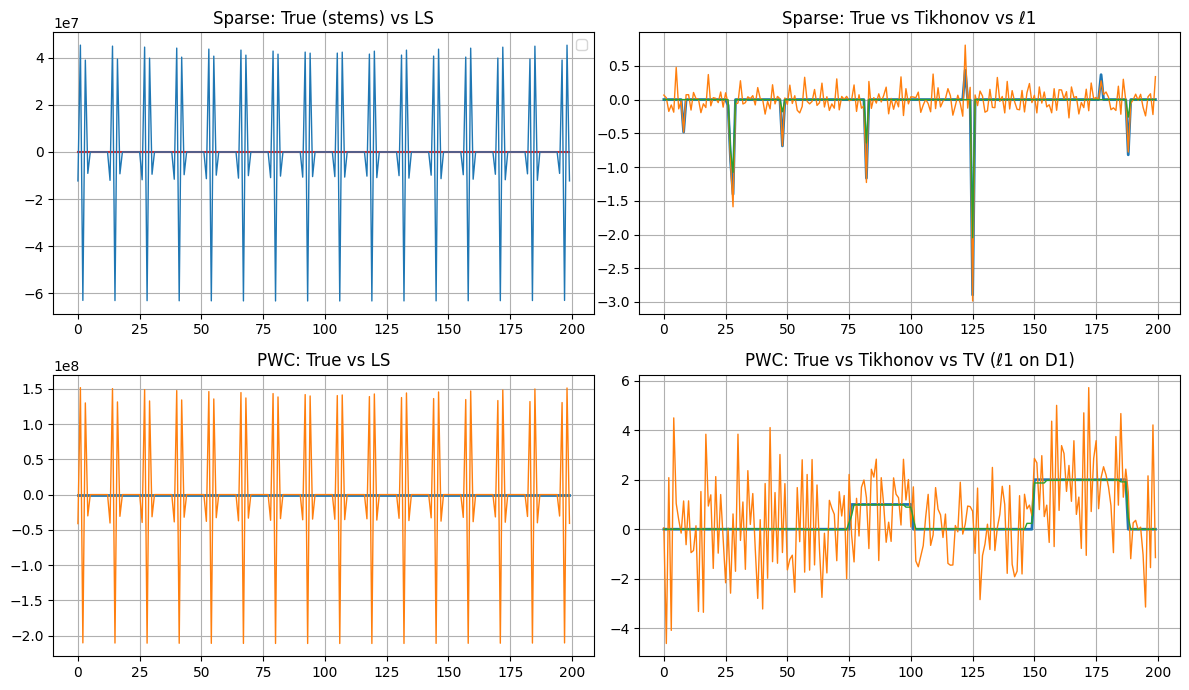

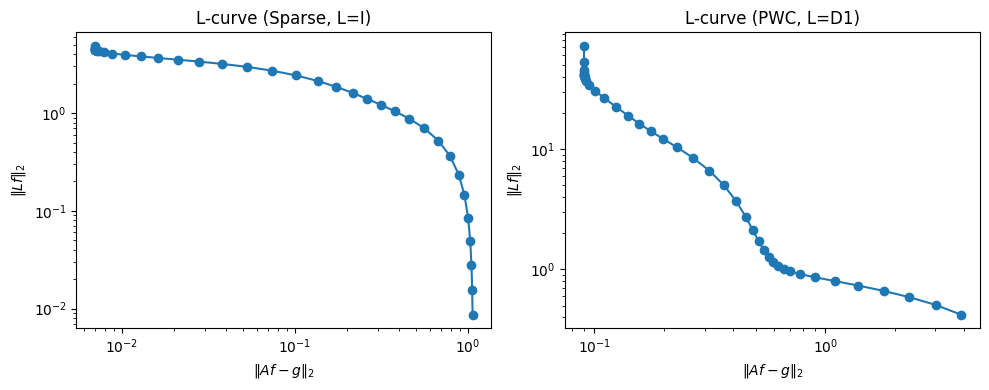

[Sparse] λ* ≈ 5.878e-04
[PWC  ] λ* ≈ 5.878e-04


In [27]:
# %% [markdown]
# ## Problem 1 — Deconvolution with Gaussian Blur and Noise

# %%
# Parameters
n = 200
m_kernel = 6
sigma = 3.0
psf = gaussian_psf_from_m_sigma(m=m_kernel, sigma=sigma)

A_zero = blur_matrix_zero_boundary(psf, n)
L_I  = identity_matrix(n)
L_D1 = diff_matrix_first(n)

# --- Case 1: Sparse signal ---
f_sparse_true = signal_sparse(n=n, s=10, scale=1.0)
g_sparse_clean = A_zero @ f_sparse_true
g_sparse_noisy, e_sparse = add_relative_noise(g_sparse_clean, rel=0.05)  # 5% noise

# LS
f_sparse_ls = solve_ls(A_zero, g_sparse_noisy)

# Tikhonov (L = I for sparse)
lams = np.logspace(-4, 1, 40)
rhos_sp, etas_sp = l_curve(A_zero, L_I, g_sparse_noisy, lams)
lam_star_sp, idx_sp, kappa_sp = pick_lambda_by_curvature(lams, rhos_sp, etas_sp)
f_sparse_tik = solve_tikhonov(A_zero, L_I, g_sparse_noisy, lam_star_sp)

# ℓ1 (L = I for sparse)
mu_sparse = 0.08  # tune if desired
f_sparse_l1 = solve_l1_cvx(A_zero, L_I, g_sparse_noisy, mu_sparse) if _HAS_CVXPY else np.full(n, np.nan)

# --- Case 2: Piecewise-constant (TV prior: L = first difference) ---
f_pwc_true = signal_piecewise_constant(n=n)
g_pwc_clean = A_zero @ f_pwc_true
g_pwc_noisy, e_pwc = add_relative_noise(g_pwc_clean, rel=0.05)  # 5%

# LS
f_pwc_ls = solve_ls(A_zero, g_pwc_noisy)

# Tikhonov with L = D1 (smoothness penalty on first differences)
lams2 = np.logspace(-4, 1, 40)
rhos_pc, etas_pc = l_curve(A_zero, L_D1, g_pwc_noisy, lams2)
lam_star_pc, idx_pc, kappa_pc = pick_lambda_by_curvature(lams2, rhos_pc, etas_pc)
f_pwc_tik = solve_tikhonov(A_zero, L_D1, g_pwc_noisy, lam_star_pc)

# TV / ℓ1 on first differences
mu_tv = 0.1
f_pwc_tv = solve_l1_cvx(A_zero, L_D1, g_pwc_noisy, mu_tv) if _HAS_CVXPY else np.full(n, np.nan)

# --- Plots ---
fig, axes = plt.subplots(2, 2, figsize=(12, 7))
axes = axes.ravel()

axes[0].stem(f_sparse_true, markerfmt=' ')
axes[0].plot(f_sparse_ls, lw=1)
axes[0].set_title("Sparse: True (stems) vs LS")

axes[1].plot(f_sparse_true, lw=2)
axes[1].plot(f_sparse_tik, lw=1)
if _HAS_CVXPY:
    axes[1].plot(f_sparse_l1, lw=1)
axes[1].set_title("Sparse: True vs Tikhonov vs ℓ1")

axes[2].plot(f_pwc_true, lw=2)
axes[2].plot(f_pwc_ls, lw=1)
axes[2].set_title("PWC: True vs LS")

axes[3].plot(f_pwc_true, lw=2)
axes[3].plot(f_pwc_tik, lw=1)
if _HAS_CVXPY:
    axes[3].plot(f_pwc_tv, lw=1)
axes[3].set_title("PWC: True vs Tikhonov vs TV (ℓ1 on D1)")

for ax in axes:
    ax.grid(True)
plt.tight_layout()
plt.show()

# L-curves (optional)
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].loglog(rhos_sp, etas_sp, marker='o')
ax[0].set_title("L-curve (Sparse, L=I)")
ax[0].set_xlabel(r"$\|A f - g\|_2$")
ax[0].set_ylabel(r"$\|L f\|_2$")

ax[1].loglog(rhos_pc, etas_pc, marker='o')
ax[1].set_title("L-curve (PWC, L=D1)")
ax[1].set_xlabel(r"$\|A f - g\|_2$")
ax[1].set_ylabel(r"$\|L f\|_2$")

plt.tight_layout();
plt.show()

print(f"[Sparse] λ* ≈ {lam_star_sp:.3e}")
print(f"[PWC  ] λ* ≈ {lam_star_pc:.3e}")


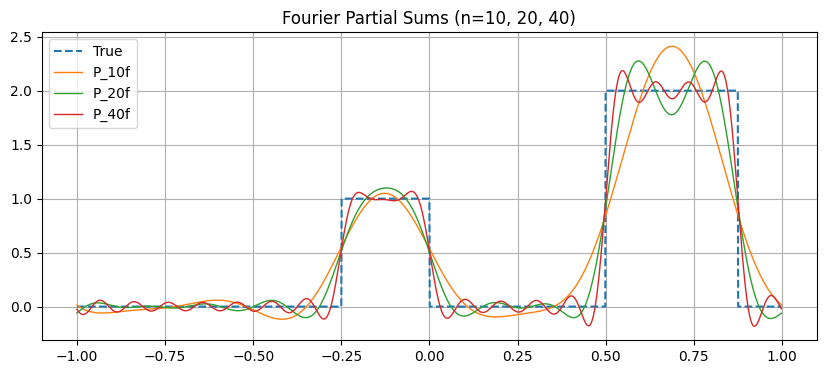

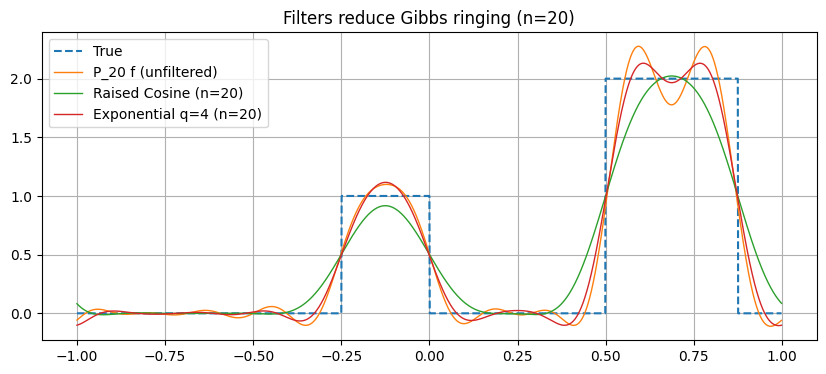

In [9]:
# %% [markdown]
# ## Problem 2 — Fourier coefficients, partial sums, and filters

# %%
def piecewise_const_hat_k(k):
    """
    Analytic Fourier coefficients:
      f̂(k) = 1/2 ∫_{-1}^1 f(t) e^{-i k π t} dt
    f(t)=1 on (-1/4,0], =2 on [1/2,7/8], else 0 (period 2).
    """
    if k == 0:
        return 0.5  # average value
    ikpi = 1j * k * np.pi
    term1 = (np.exp(0) - np.exp(ikpi/4)) / (-ikpi)                     # ∫_{-1/4}^{0} 1*e^{-ikπt} dt
    term2 = 2 * (np.exp(-ikpi*7/8) - np.exp(-ikpi*1/2)) / (-ikpi)      # ∫_{1/2}^{7/8} 2*e^{-ikπt} dt
    return 0.5 * (term1 + term2)

def fourier_partial_sum(n, t):
    # modes k = -n/2,...,n/2
    ks = np.arange(-n//2, n//2 + 1)
    out = np.zeros_like(t, dtype=np.complex128)
    for k in ks:
        out += piecewise_const_hat_k(k) * np.exp(1j * k * np.pi * t)
    return out

def raised_cosine_filter(k, N):
    # σ_RC(k) = 0.5*(1+cos(π k / N)) on |k|<=N, else 0
    sig = 0.5 * (1 + np.cos(np.pi * k / N))
    sig[np.abs(k) > N] = 0.0
    return sig

def exponential_filter(k, N, q=4):
    # σ_exp(k) = exp(-( |k|/N )^q )
    sig = np.exp(- (np.abs(k)/N)**q )
    sig[np.abs(k) > N] = 0.0
    return sig

# --- Plot partial sums n=10,20,40 ---
t_fine = np.linspace(-1, 1, 2000, endpoint=False)
f_true = signal_piecewise_constant(n=len(t_fine))  # discrete version for plotting

fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(t_fine, f_true, linestyle='--', lw=1.5, label='True')

for n_plot in [10, 20, 40]:
    f_ps = fourier_partial_sum(n_plot, t_fine)
    ax.plot(t_fine, np.real(f_ps), lw=1, label=f"P_{n_plot}f")

ax.set_title("Fourier Partial Sums (n=10, 20, 40)")
ax.legend(); ax.grid(True); plt.show()

# --- Filters for n=20 ---
n0 = 20
ks = np.arange(-n0//2, n0//2 + 1)
fhat = np.array([piecewise_const_hat_k(k) for k in ks])

# Unfiltered
f_ps20 = np.sum(fhat[:,None] * np.exp(1j * ks[:,None] * np.pi * t_fine[None,:]), axis=0)

# Raised cosine (order ~2)
sigma_rc = raised_cosine_filter(ks, N=n0//2)
f_rc = np.sum((sigma_rc*fhat)[:,None] * np.exp(1j * ks[:,None] * np.pi * t_fine[None,:]), axis=0)

# Exponential filter (q=4)
sigma_exp = exponential_filter(ks, N=n0//2, q=4)
f_ex = np.sum((sigma_exp*fhat)[:,None] * np.exp(1j * ks[:,None] * np.pi * t_fine[None,:]), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(t_fine, f_true, linestyle='--', lw=1.5, label='True')
ax.plot(t_fine, np.real(f_ps20), lw=1, label='P_20 f (unfiltered)')
ax.plot(t_fine, np.real(f_rc), lw=1, label='Raised Cosine (n=20)')
ax.plot(t_fine, np.real(f_ex), lw=1, label='Exponential q=4 (n=20)')
ax.set_title("Filters reduce Gibbs ringing (n=20)")
ax.legend(); ax.grid(True); plt.show()


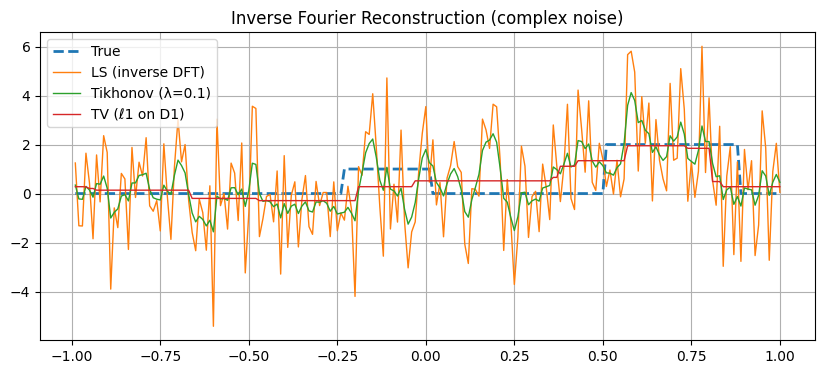

In [11]:
# %% [markdown]
# ## Problem 3 — Inverse Fourier problem with complex noise

# %%
def dft_matrix_assignment(n):
    # F(l,j) = (1/n) * exp( -i (l - n/2 - 1) π t_j ), with t_j = -1 + 2j/n, j=1..n, l=1..n
    j = np.arange(1, n+1)
    t = -1 + 2*j/n
    l = np.arange(1, n+1)
    K = (l - (n/2) - 1)[:, None]  # shape (n,1)
    F = (1/n) * np.exp(-1j * (K * np.pi) * t[None, :])
    return F, t

# Use the same piecewise-constant function as in Problem 1
n = 200
f_true = signal_piecewise_constant(n)
F, tgrid = dft_matrix_assignment(n)

# Noiseless coefficients and noisy data
b_clean = F @ f_true
eta = 0.2  # noise std
b_noisy, e = add_complex_noise(b_clean, eta=eta)

# Least-squares (complex)
f_ls = npl.lstsq(F, b_noisy, rcond=None)[0]

# Tikhonov (complex), L = D1
L = diff_matrix_first(n)
FHF = F.conj().T @ F
LTL = L.T @ L
rhs = F.conj().T @ b_noisy

lam = 0.1
f_tik = spla.solve(FHF + (lam**2)*LTL, rhs, assume_a='pos')

# TV / ℓ1 in complex (if cvxpy available)
if _HAS_CVXPY:
    f_var = cp.Variable(n, complex=True)
    obj = cp.sum_squares(F @ f_var - b_noisy) + 0.08 * cp.norm1(L @ f_var)
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve(verbose=False, solver=cp.SCS)
    f_tv = f_var.value
else:
    f_tv = np.full(n, np.nan, dtype=np.complex128)

# Plot (real part; true is real)
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(tgrid, f_true, lw=2, linestyle='--', label='True')
ax.plot(tgrid, np.real(f_ls), lw=1, label='LS (inverse DFT)')
ax.plot(tgrid, np.real(f_tik), lw=1, label=f'Tikhonov (λ={lam})')
if _HAS_CVXPY:
    ax.plot(tgrid, np.real(f_tv), lw=1, label='TV (ℓ1 on D1)')
ax.set_title("Inverse Fourier Reconstruction (complex noise)")
ax.legend(); ax.grid(True); plt.show()


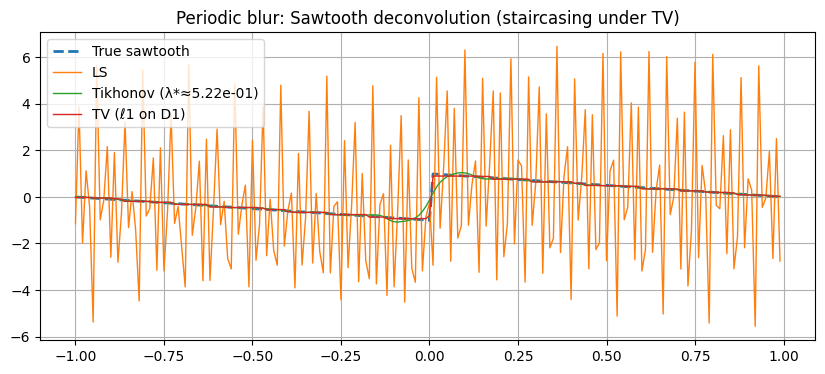

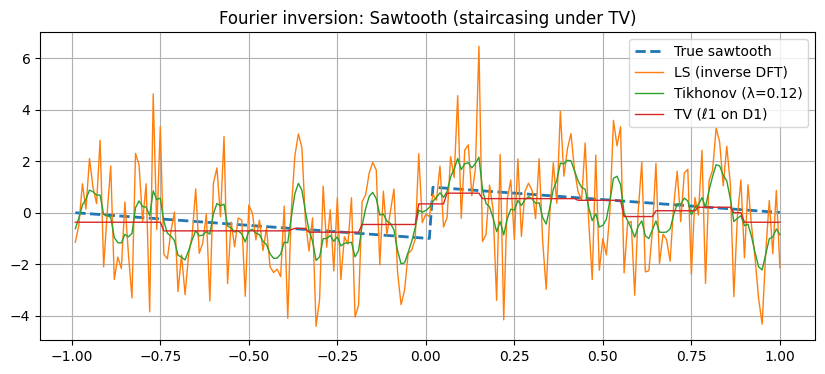

In [13]:
# %% [markdown]
# ## Problem 4 (Bonus) — Sawtooth with periodic blur and Fourier inversion

# %%
n = 200
f_saw = signal_sawtooth(n)
psf = gaussian_psf_from_m_sigma(m=6, sigma=2.5)

# --- Periodic blur case (circulant A) ---
A_per = blur_matrix_periodic(psf, n)
g_clean = A_per @ f_saw
g_noisy, e = add_relative_noise(g_clean, rel=0.05)

# LS (deconvolution)
f_ls_saw = solve_ls(A_per, g_noisy)

# Tikhonov (L = D1)
L = diff_matrix_first(n)
lams = np.logspace(-4, 1, 40)
rhos_s, etas_s = l_curve(A_per, L, g_noisy, lams)
lam_star, idx_star, _ = pick_lambda_by_curvature(lams, rhos_s, etas_s)
f_tik_saw = solve_tikhonov(A_per, L, g_noisy, lam_star)

# TV (ℓ1 on D1) — staircasing expected
mu_tv = 0.12
f_tv_saw = solve_l1_cvx(A_per, L, g_noisy, mu_tv) if _HAS_CVXPY else np.full(n, np.nan)

# Plot periodic blur recon
t = -1 + 2*np.arange(n)/n
fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(t, f_saw, lw=2, linestyle='--', label='True sawtooth')
ax.plot(t, f_ls_saw, lw=1, label='LS')
ax.plot(t, f_tik_saw, lw=1, label=f'Tikhonov (λ*≈{lam_star:.2e})')
if _HAS_CVXPY:
    ax.plot(t, f_tv_saw, lw=1, label='TV (ℓ1 on D1)')
ax.set_title("Periodic blur: Sawtooth deconvolution (staircasing under TV)")
ax.legend(); ax.grid(True); plt.show()

# --- Fourier inversion for sawtooth (complex noise) ---
F, tgrid = dft_matrix_assignment(n)
b_clean = F @ f_saw
b_noisy, _ = add_complex_noise(b_clean, eta=0.2)

# LS
f_ls_F = npl.lstsq(F, b_noisy, rcond=None)[0]
# Tikhonov
FHF = F.conj().T @ F
rhs = F.conj().T @ b_noisy
lam = 0.12
f_tik_F = spla.solve(FHF + (lam**2)*(L.T@L), rhs, assume_a='pos')
# TV (if cvxpy)
if _HAS_CVXPY:
    f_var = cp.Variable(n, complex=True)
    obj = cp.sum_squares(F @ f_var - b_noisy) + 0.08*cp.norm1(L @ f_var)
    prob = cp.Problem(cp.Minimize(obj))
    prob.solve(verbose=False, solver=cp.SCS)
    f_tv_F = f_var.value
else:
    f_tv_F = np.full(n, np.nan, dtype=np.complex128)

fig, ax = plt.subplots(1, 1, figsize=(10,4))
ax.plot(tgrid, f_saw, lw=2, linestyle='--', label='True sawtooth')
ax.plot(tgrid, np.real(f_ls_F), lw=1, label='LS (inverse DFT)')
ax.plot(tgrid, np.real(f_tik_F), lw=1, label=f'Tikhonov (λ={lam})')
if _HAS_CVXPY:
    ax.plot(tgrid, np.real(f_tv_F), lw=1, label='TV (ℓ1 on D1)')
ax.set_title("Fourier inversion: Sawtooth (staircasing under TV)")
ax.legend(); ax.grid(True); plt.show()
